# Check the enviroment for GPU setting

In [51]:
import tensorflow as tf 
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4175973107824607665
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18334065631772362187
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
xla_global_id: 416903419
]


2024-05-02 06:02:13.948624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 06:02:13.948895: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 06:02:13.949036: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [52]:
!nvidia-smi

Thu May  2 06:02:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P0              32W /  70W |  14085MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [53]:
!pip install yfinance

# Import dataset and necessary libraries

In [55]:
import pandas as pd
import numpy as np
import yfinance as yf
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

crypto_news_df = pd.read_csv('data/cryptonews.csv')
crypto_news_df.head()

,date,sentiment,source,subject,text,title,url
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...


### Extract 'sentiment' column and make them into seperate columns

In [5]:
def extract_sentiment_values(sentiment_str):
    sentiment_dict = ast.literal_eval(sentiment_str)
    return sentiment_dict['class'], sentiment_dict['polarity'], sentiment_dict['subjectivity']

crypto_news_df[['sentiment_class', 'polarity', 'subjectivity']] = crypto_news_df['sentiment'].apply(lambda x: pd.Series(extract_sentiment_values(x)))

crypto_news_df['date'] = pd.to_datetime(crypto_news_df['date'], infer_datetime_format=True, errors='coerce')
crypto_news_df['date'] = crypto_news_df['date'].dt.strftime('%Y-%m-%d')

def clean_url(url):
    if 'https' in url:
        parts = url.split('https')
        return 'https' + parts[-1]
    else:
        return url

crypto_news_df['url'] = crypto_news_df['url'].apply(clean_url)

crypto_news_df

,date,sentiment,source,subject,text,title,url,sentiment_class,polarity,subjectivity
0,2023-12-19,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.com/news/grayscale-ceo-call...,negative,-0.10,0.60
1,2023-12-19,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.com/news/indian-government-...,neutral,0.00,0.00
2,2023-12-19,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.com/news/judge-approves-set...,positive,0.05,0.05
3,2023-12-19,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...,positive,0.50,0.90
4,2023-12-19,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...,neutral,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
31032,2021-10-27,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,defi,Cream Finance (CREAM) suffered another flash l...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...,neutral,0.00,0.00
31033,2021-10-19,"{'class': 'positive', 'polarity': 0.1, 'subjec...",CryptoNews,blockchain,Banque de France disclosed the results of its ...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...,positive,0.10,0.40
31034,2021-10-18,"{'class': 'positive', 'polarity': 0.14, 'subje...",CryptoNews,blockchain,Advancing its project to become \x9caÂ\xa0meta...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...,positive,0.14,0.45
31035,2021-10-15,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,Chinese companies are still topping the blockc...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...,neutral,0.00,0.00


In [6]:
crypto_news_df.columns

Index(['date', 'sentiment', 'source', 'subject', 'text', 'title', 'url',
       'sentiment_class', 'polarity', 'subjectivity'],
      dtype='object')

# Getting Bitcoin price data from Yahoo finance API

In [7]:
start_date = '2021-10-12'
end_date = '2023-12-19'

btc_prices = yf.download(tickers='BTC-USD', start=start_date, end=end_date, interval='1d')

btc_prices

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-12,57526.832031,57627.878906,54477.972656,56041.058594,56041.058594,41083758949
2021-10-13,56038.257812,57688.660156,54370.972656,57401.097656,57401.097656,41684252783
2021-10-14,57372.832031,58478.734375,56957.074219,57321.523438,57321.523438,36615791366
2021-10-15,57345.902344,62757.128906,56868.144531,61593.949219,61593.949219,51780081801
2021-10-16,61609.527344,62274.476562,60206.121094,60892.179688,60892.179688,34250964237
...,...,...,...,...,...,...
2023-12-14,42884.261719,43390.859375,41767.089844,43023.972656,43023.972656,25578530178
2023-12-15,43028.250000,43087.824219,41692.968750,41929.757812,41929.757812,19639442462
2023-12-16,41937.742188,42664.945312,41723.113281,42240.117188,42240.117188,14386729590


In [8]:
btc_prices.reset_index(inplace=True)
btc_prices.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

### Generate final dataset by merging sentiment dataset and Bitcoin price dataset

In [9]:
crypto_news_df['date'] = pd.to_datetime(crypto_news_df['date'])

final_data = pd.merge(crypto_news_df, btc_prices, left_on='date', right_on='Date', how='inner')
final_data.head()

,date,sentiment,source,subject,text,title,url,sentiment_class,polarity,subjectivity,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-12-18,"{'class': 'positive', 'polarity': 0.01, 'subje...",CoinTelegraph,altcoin,"The new CEO, Josh Swihart, has been the vice p...",Zcash founder Zooko Wilcox steps down from Ele...,https://cointelegraph.com/news/zcash-founder-z...,positive,0.01,0.38,2023-12-18,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
1,2023-12-18,"{'class': 'positive', 'polarity': 0.15, 'subje...",CryptoNews,blockchain,NASDAQ-listed Bitcoin mining firm Cipher Minin...,"Cipher Scales BTC Mining Operation with 37,000...",https://cryptonews.com/news/cipher-scales-btc-...,positive,0.15,0.65,2023-12-18,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
2,2023-12-18,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,South Korean crypto market analysts think the ...,South Korean Analysts: Global Crypto Market Ca...,https://cryptonews.com/news/south-korean-analy...,neutral,0.00,0.00,2023-12-18,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
3,2023-12-18,"{'class': 'positive', 'polarity': 0.6, 'subjec...",CryptoPotato,altcoin,Tether asserts to have effectively immobilized...,Tether Reveals Partnerships with Secret Servic...,https://cryptopotato.com/tether-reveals-partne...,positive,0.60,0.80,2023-12-18,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
4,2023-12-18,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,altcoin,Here is our weekly collection of digital asset...,Crypto Exchange Listing and Delisting Announce...,https://cryptonews.com/news/crypto-exchange-li...,neutral,0.00,0.03,2023-12-18,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008


In [10]:
final_data.drop(columns=['Date', 'sentiment'], inplace=True)
final_data

,date,source,subject,text,title,url,sentiment_class,polarity,subjectivity,Open,High,Low,Close,Adj Close,Volume
0,2023-12-18,CoinTelegraph,altcoin,"The new CEO, Josh Swihart, has been the vice p...",Zcash founder Zooko Wilcox steps down from Ele...,https://cointelegraph.com/news/zcash-founder-z...,positive,0.01,0.38,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
1,2023-12-18,CryptoNews,blockchain,NASDAQ-listed Bitcoin mining firm Cipher Minin...,"Cipher Scales BTC Mining Operation with 37,000...",https://cryptonews.com/news/cipher-scales-btc-...,positive,0.15,0.65,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
2,2023-12-18,CryptoNews,blockchain,South Korean crypto market analysts think the ...,South Korean Analysts: Global Crypto Market Ca...,https://cryptonews.com/news/south-korean-analy...,neutral,0.00,0.00,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
3,2023-12-18,CryptoPotato,altcoin,Tether asserts to have effectively immobilized...,Tether Reveals Partnerships with Secret Servic...,https://cryptopotato.com/tether-reveals-partne...,positive,0.60,0.80,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
4,2023-12-18,CryptoNews,altcoin,Here is our weekly collection of digital asset...,Crypto Exchange Listing and Delisting Announce...,https://cryptonews.com/news/crypto-exchange-li...,neutral,0.00,0.03,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31022,2021-10-27,CryptoNews,defi,Cream Finance (CREAM) suffered another flash l...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...,neutral,0.00,0.00,60352.000000,61435.183594,58208.187500,58482.386719,58482.386719,43657076893
31023,2021-10-19,CryptoNews,blockchain,Banque de France disclosed the results of its ...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...,positive,0.10,0.40,62043.164062,64434.535156,61622.933594,64261.992188,64261.992188,40471196346
31024,2021-10-18,CryptoNews,blockchain,Advancing its project to become \x9caÂ\xa0meta...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...,positive,0.14,0.45,61548.804688,62614.660156,60012.757812,62026.078125,62026.078125,38055562075
31025,2021-10-15,CryptoNews,blockchain,Chinese companies are still topping the blockc...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...,neutral,0.00,0.00,57345.902344,62757.128906,56868.144531,61593.949219,61593.949219,51780081801


In [11]:
final_data.columns

Index(['date', 'source', 'subject', 'text', 'title', 'url', 'sentiment_class',
       'polarity', 'subjectivity', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume'],
      dtype='object')

In [12]:
final_data['date'] = pd.to_datetime(final_data['date'])

missing_values = final_data.isnull().sum()
missing_values

date               0
source             0
subject            0
text               0
title              0
url                0
sentiment_class    0
polarity           0
subjectivity       0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
dtype: int64

In [13]:
# Encode 'sentiment_class' as -1, 0, 1
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
final_data['sentiment_class'] = final_data['sentiment_class'].map(sentiment_mapping)
final_data

,date,source,subject,text,title,url,sentiment_class,polarity,subjectivity,Open,High,Low,Close,Adj Close,Volume
0,2023-12-18,CoinTelegraph,altcoin,"The new CEO, Josh Swihart, has been the vice p...",Zcash founder Zooko Wilcox steps down from Ele...,https://cointelegraph.com/news/zcash-founder-z...,1,0.01,0.38,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
1,2023-12-18,CryptoNews,blockchain,NASDAQ-listed Bitcoin mining firm Cipher Minin...,"Cipher Scales BTC Mining Operation with 37,000...",https://cryptonews.com/news/cipher-scales-btc-...,1,0.15,0.65,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
2,2023-12-18,CryptoNews,blockchain,South Korean crypto market analysts think the ...,South Korean Analysts: Global Crypto Market Ca...,https://cryptonews.com/news/south-korean-analy...,0,0.00,0.00,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
3,2023-12-18,CryptoPotato,altcoin,Tether asserts to have effectively immobilized...,Tether Reveals Partnerships with Secret Servic...,https://cryptopotato.com/tether-reveals-partne...,1,0.60,0.80,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
4,2023-12-18,CryptoNews,altcoin,Here is our weekly collection of digital asset...,Crypto Exchange Listing and Delisting Announce...,https://cryptonews.com/news/crypto-exchange-li...,0,0.00,0.03,41348.203125,42720.296875,40530.257812,42623.539062,42623.539062,25224642008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31022,2021-10-27,CryptoNews,defi,Cream Finance (CREAM) suffered another flash l...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...,0,0.00,0.00,60352.000000,61435.183594,58208.187500,58482.386719,58482.386719,43657076893
31023,2021-10-19,CryptoNews,blockchain,Banque de France disclosed the results of its ...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...,1,0.10,0.40,62043.164062,64434.535156,61622.933594,64261.992188,64261.992188,40471196346
31024,2021-10-18,CryptoNews,blockchain,Advancing its project to become \x9caÂ\xa0meta...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...,1,0.14,0.45,61548.804688,62614.660156,60012.757812,62026.078125,62026.078125,38055562075
31025,2021-10-15,CryptoNews,blockchain,Chinese companies are still topping the blockc...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...,0,0.00,0.00,57345.902344,62757.128906,56868.144531,61593.949219,61593.949219,51780081801


# Check the correlation between sentiment scores and Bitcoin price

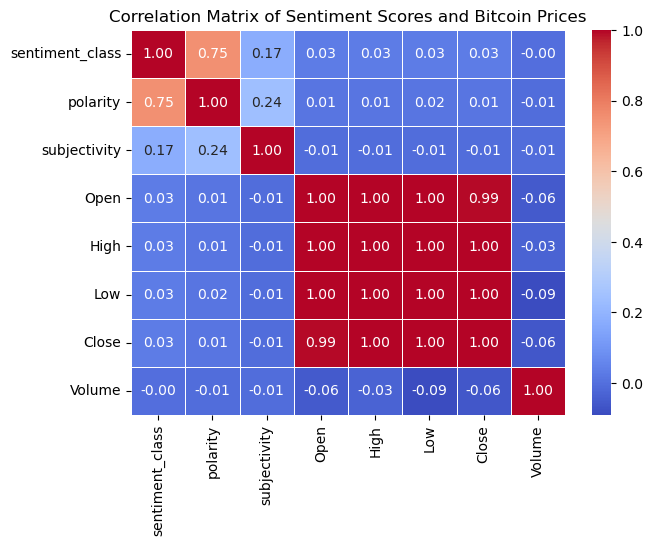

In [14]:
correlation_data = final_data[['sentiment_class', 'polarity', 'subjectivity', 'Open', 'High', 'Low', 'Close', 'Volume']]
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Sentiment Scores and Bitcoin Prices')
plt.show()

Polarity shows very low correlation with all Bitcoin price metrics. It means that the overall positive or negative tone of the news doesn't strongly relate to daily price changes.

Subjectivity also exhibits very low correlation with Bitcoin price metrics, indicating that the degree of subjectivity or objectivity in the news isn't significantly associated with price movements.

# Fit the Random Forest Regressor to see the feature importance

In [15]:
extract_data = final_data[['sentiment_class', 'polarity', 'subjectivity', 'Open', 'High', 'Low', 'Volume', 'Close']]


X = extract_data[['sentiment_class', 'polarity', 'subjectivity', 'Open', 'High', 'Low', 'Volume']]
y = extract_data['Close']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and calculate the Mean Squared Error
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Feature importance
feature_importance = rf_model.feature_importances_

feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)
print('\n')
print(mse)

           Feature    Importance
4             High  7.827113e-01
5              Low  2.085601e-01
3             Open  8.263805e-03
6           Volume  4.642420e-04
1         polarity  3.880212e-07
0  sentiment_class  1.413162e-07
2     subjectivity  8.833108e-08


2030.3247878260352


Feature Importance indicates the relative importance of each feature in predicting Bitcoin's closing price:

1. High: 78.27% importance
2. Low: 20.86% importance
3. Open: 0.83% importance
4. Volume: 0.046% importance
5. Polarity: 0.000038% importance
6. Sentiment Class: 0.000014% importance
7. Subjectivity: 0.0000088% importance

From this analysis, I can conclude sentiment-related features, including sentiment class, polarity, and subjectivity, have negligible importance in predicting Bitcoin's closing price according to this model.

An MSE of 2030.32 means that, on average, the model's predictions deviate from the actual closing prices by the square root of this number, which would be approximately $45.06. This deviation is the average error in the model's predictions of Bitcoin's closing price.

# Predict future price of Bitcoin using LSTM

After observing that there is no significant correlation between sentiment analysis and Bitcoin price movements, I will shift my focus to exploring the LSTM method for further analysis.

In [34]:
start_date = '2016-01-01'
end_date = '2024-03-31'

bitcoin = yf.download(tickers='BTC-USD', start=start_date, end=end_date, interval='1d')
bitcoin

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600
...,...,...,...,...,...,...
2024-03-26,69931.328125,71535.742188,69335.609375,69987.835938,69987.835938,36010437368
2024-03-27,69991.898438,71727.687500,68381.929688,69455.343750,69455.343750,40827113309
2024-03-28,69452.773438,71546.023438,68895.507812,70744.953125,70744.953125,34374900617


## Visualizing close price chart

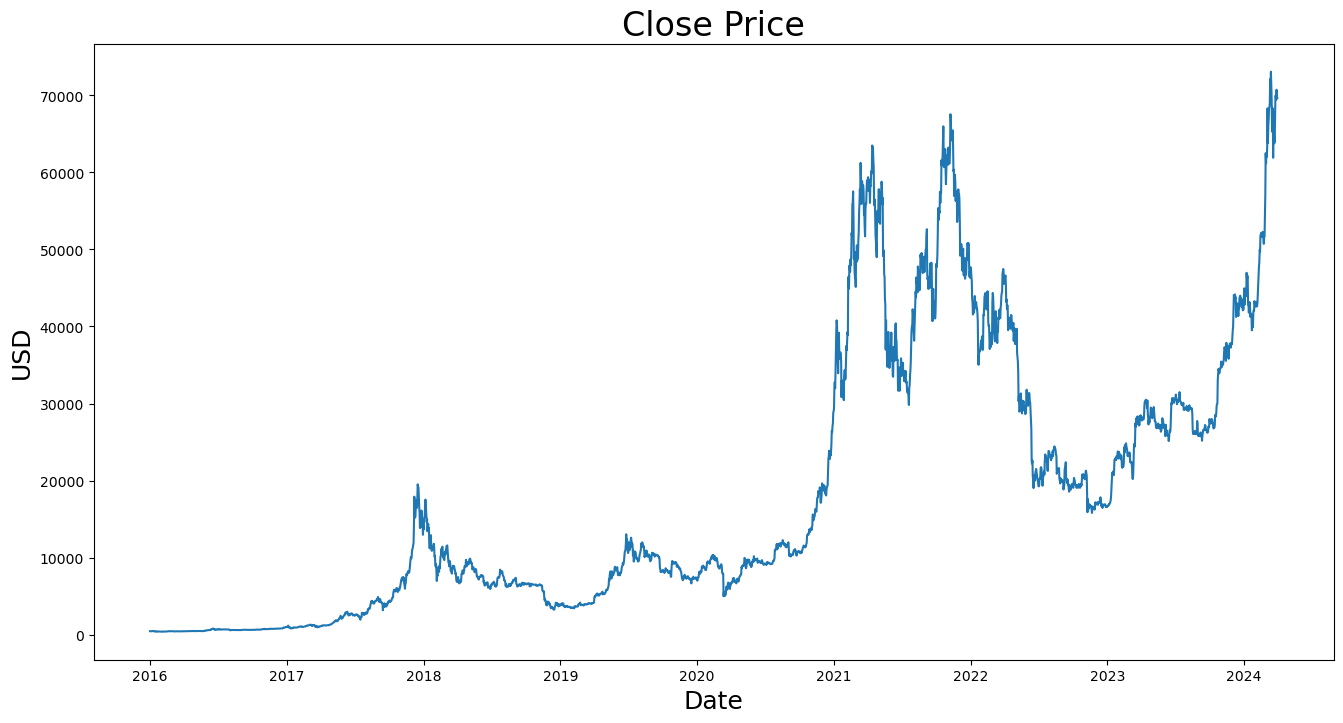

In [35]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(bitcoin['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

In [36]:
# Divide training and test sets
bitcoin_close_df = bitcoin.filter(['Close'])
bitcoin_close = bitcoin_close_df.values.reshape(-1, 1)

training_data_len = math.ceil(len(bitcoin_close) * 0.8)
training_data_len

2410

In [37]:
# Scaling closing price with MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(bitcoin_close)
scaled_close

array([[9.62648806e-04],
       [9.50327067e-04],
       [9.03200539e-04],
       ...,
       [9.67841397e-01],
       [9.56123373e-01],
       [9.52719546e-01]])

### This model will predict the price by looking back the last 60 days of price

In [38]:
# Creat the train dataset
train_data = scaled_close[0:training_data_len, :]

# Split the data into X_train and y_train dataset
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])

# Convert the X_train and y_train to array
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(2350, 60)

In [39]:
# Reshape the data for 3 dimension to apply LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2350, 60, 1)

In [40]:
# Create the test dataset
test_data = scaled_close[training_data_len - 60 : , :]

#Create the dataset X_test and y_test
X_test = []
y_test = bitcoin_close[training_data_len : , :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60 : i, 0])

In [41]:
# Convert the data to array 
X_test = np.array(X_test)

# Reshape the test data for 3 dimensions
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [42]:
# LSTM model
tf.random.set_seed(42)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [43]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [44]:
# Train the model with 10 epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2350/2350 [==============================] - 16s 6ms/step - loss: 0.0013
Epoch 2/10
2350/2350 [==============================] - 14s 6ms/step - loss: 6.5770e-04
Epoch 3/10
2350/2350 [==============================] - 14s 6ms/step - loss: 5.6004e-04
Epoch 4/10
2350/2350 [==============================] - 14s 6ms/step - loss: 4.4727e-04
Epoch 5/10
2350/2350 [==============================] - 13s 6ms/step - loss: 4.6073e-04
Epoch 6/10
2350/2350 [==============================] - 13s 6ms/step - loss: 3.9242e-04
Epoch 7/10
2350/2350 [==============================] - 13s 6ms/step - loss: 3.9796e-04
Epoch 8/10
2350/2350 [==============================] - 14s 6ms/step - loss: 3.0988e-04
Epoch 9/10
2350/2350 [==============================] - 14s 6ms/step - loss: 3.0751e-04
Epoch 10/10
2350/2350 [==============================] - 14s 6ms/step - loss: 3.4494e-04


In [45]:
# Get predicted values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
len(predictions)

19/19 [==============================] - 1s 3ms/step


602

In [46]:
#Check rmse for evaluation
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

700.1293896646595

/tmp/ipykernel_19859/2997036282.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


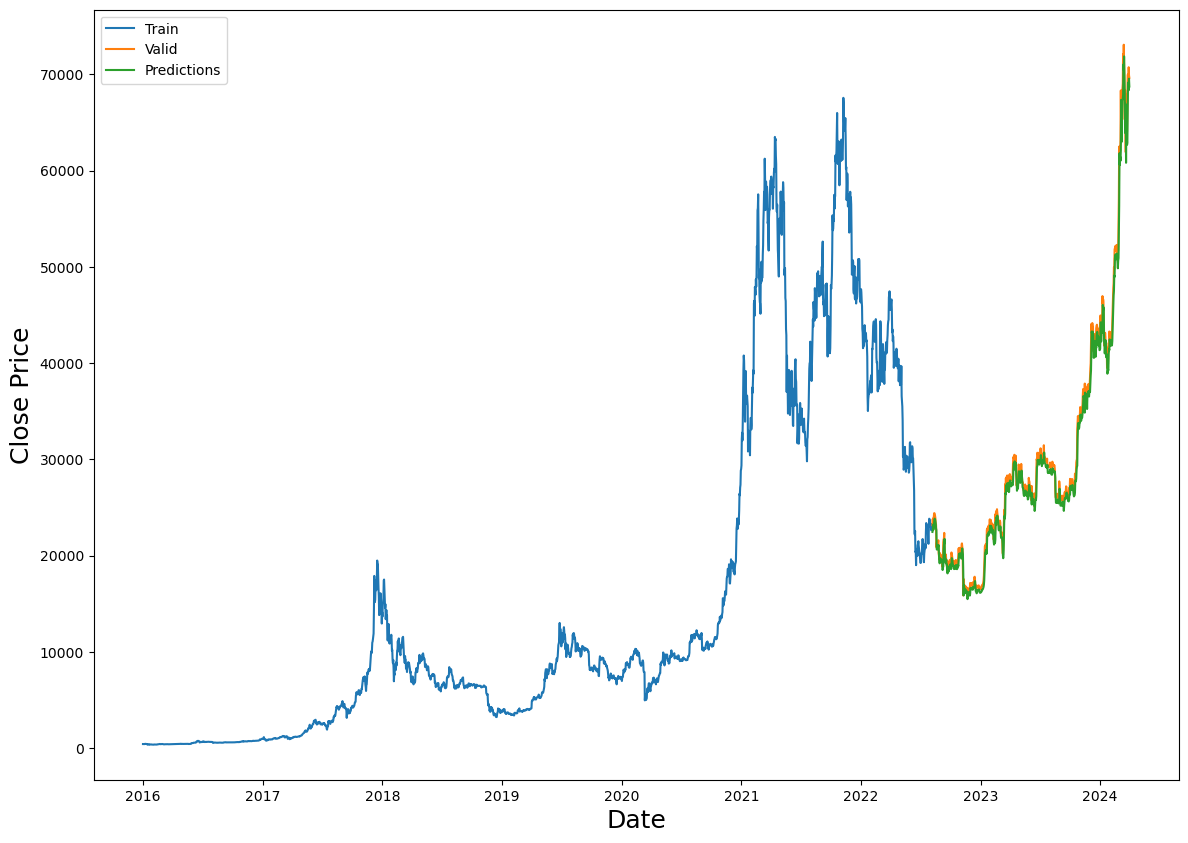

In [47]:
# Divide into train and valid dataset
train = bitcoin_close_df[:training_data_len]
valid = bitcoin_close_df[training_data_len:]
valid['Predictions'] = predictions

# Visualized the data 
plt.figure(figsize=(14, 10))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')
plt.show()

# Predict Bitcoin price on April 1st

In [48]:
#Get the last 60 day closing price values
last_60_days = bitcoin_close_df[-60:].values

# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)

new_X_test = []
new_X_test.append(last_60_days_scaled)
new_X_test = np.array(new_X_test)

# Reshape the data for 3 dimensions
new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))

pred_price = model.predict(new_X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 20ms/step
[[69128.48]]
